# Tutorial \#4: Coverage Prediction using Geo2SigMap's ML Model and Comparison with Measurement Data

This tutorial demonstrates the complete workflow for:
1. **Scene Generation**: Creating 2D building maps for specified PCI locations;
2. **Data Preparation**: Processing real-world measurement data;
3. **Model Inference**:
  - 1st U-Net: Isotropic antenna pattern prediction;
  - 2nd U-Net: Fine-grained prediction with sparse measurements;
4. **Performance Evaluation**: Quantitative comparison with ground truth (field measurements).

**Technical Specifications**:
- Area size: 512m x 512m;
- Spatial resolution: 4m x 4m (per pixel);
- Model input/output dimension: 128 × 128 (pixel x pixel)

**Prerequisites**:
- Please make sure that **PyTorch** is installed: check the [PyTorch website](https://pytorch.org/get-started/locally/) for more info.;
- Download the pre-trained model weights for Geo2SigMap's deep learning (DL) model and save them to `data/model_unet/`.

In [1]:
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random

from scene_generation.core import Scene
from scene_generation.utils import *
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from scipy.io import loadmat

import os
import glob


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2025-03-09 23:46:40.048428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 23:46:40.050263: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 23:46:40.077658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 23:46:40.077682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 23:46:40.078825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Experimental Setup

**Configuration**:
- Target PCI: A
- Measurement device: Samsung
- Number of sparse measurement samples input to the DL model: 200

Make sure you download the pre-trained model weights from our github repo's release page and put them under `data/ml` folder.

For detailed information about the measurement device and PCI, refer to our [paper](https://arxiv.org/pdf/2312.14303).

In [2]:
mea_device = "Samsung"
which_PCI = 0
SS_NUM = 10
RESOLUTION = 4

rt_dict = {
    "rel_top_left_x":[],
    "rel_top_left_y":[],
    "rel_center_x":[],
    "rel_center_y":[],
}


scene_dir = "../scenes/ND_{}".format(which_PCI)

state_dict_1st_UNet = "../data/model_unet/1st_checkpoint_epoch58.pth"
state_dict_2nd_UNet = "../data/model_unet/2nd_checkpoint_epoch110.pth"


data = {
    'BS':[],
    'PCI': [],
    'azimuth':[],
    'downtilt':[],
    'tx_height': [],
    'freq':[],
    'center_lat_lon': [],
    'top-left_lat_lon':[]
    
}

df = pd.DataFrame(data)


# Convert column "B" to store lists
df["center_lat_lon"] = df["center_lat_lon"].astype(object)
df["top-left_lat_lon"] = df["top-left_lat_lon"].astype(object)

                                                
df.loc[len(df)] = {'BS':None, 'PCI': 0, 'azimuth':120, 'downtilt':4, 'tx_height': 2.5, 'freq':3.67e9, 'center_lat_lon': (40.017108, -105.27926), "top-left_lat_lon":(0,0)}

for index, row in df.iterrows():
    bbox = rect_from_point_and_size(
        row["center_lat_lon"][1],
        row["center_lat_lon"][0],
        "center", 
        512,
        512
    )
    df.at[index, "top-left_lat_lon"] = (bbox[1][1], bbox[0][0])
    

df


cell_info_df = df


cell_info_df


,BS,PCI,azimuth,downtilt,tx_height,freq,center_lat_lon,top-left_lat_lon
0,None,0,120,4,2.5,3.670000e+09,"(40.017108, -105.27926)","(40.019407206686786, -105.28225028382427)"


## 1. Scene Generation

Different from the CLI tools `scenegen`, here we will directly use the Python function API to generate the scene. The Python function provides more flexibility than the CLI tool for advanced use cases.


In [3]:
polygon_points_gps = rect_from_point_and_size(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'].item()[1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'].item()[0],
    "top-left", 
    512,
    512
)
min_lon, min_lat = polygon_points_gps[0]
max_lon, max_lat = polygon_points_gps[2]
print(
    f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
)

scene_instance = Scene()
scene_instance(
    polygon_points_gps,
    scene_dir,
    None,
    osm_server_addr="https://overpass-api.de/api/interpreter",
    lidar_calibration=False,
    generate_building_map=True
)

utm_epsg = get_utm_epsg_code_from_gps(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'].item()[1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'].item()[0],
)

Check the bbox at http://bboxfinder.com/#40.0148,-105.2822,40.0194,-105.2763


Parsing buildings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 619.90it/s]


In [4]:

# Load scene and access Mitsuba's internal representation
scene = load_scene(os.path.join(scene_dir,"scene.xml"))

# Interative 3D visualization and view of the scene
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

Original Building Map Shape: (512, 513)
Cropped Building Map Shape:  (512, 512)


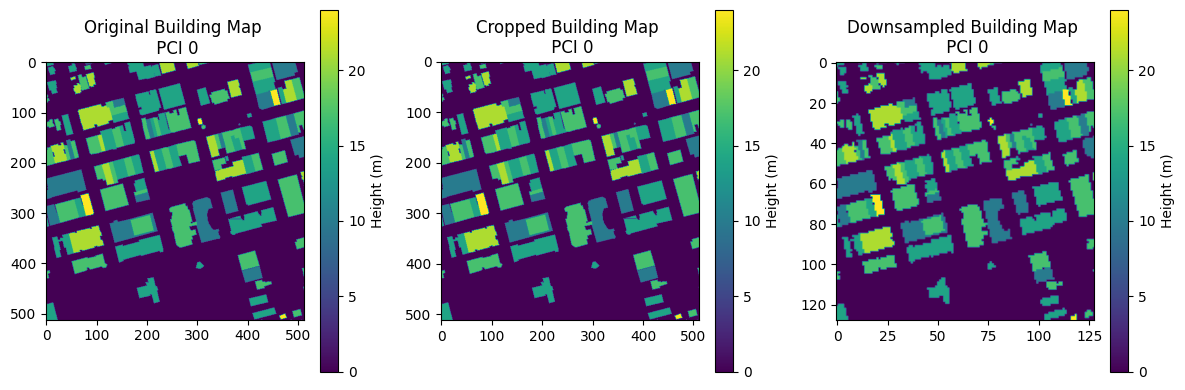

In [5]:
building_map_npy_ori = np.load("{}/2D_Building_Height_Map.npy".format(scene_dir))

print("Original Building Map Shape:", building_map_npy_ori.shape)
building_map_npy = get_center_subarray(building_map_npy_ori, 512, 512)
print("Cropped Building Map Shape: ", building_map_npy.shape)

building_map_npy_res_4 = building_map_npy[::4,::4]

# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Original building map
im_ori_bmap = axes[0].imshow(building_map_npy_ori)
axes[0].set_title('Original Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_ori_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) Cropped building map (center 512x512 subarray)
im_cropped_bmap = axes[1].imshow(building_map_npy)
axes[1].set_title('Cropped Building Map \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_cropped_bmap, ax=axes[1])
cbar_db.set_label('Height (m)')

# 3) Down sampled building map
im_ds_bmap = axes[2].imshow(building_map_npy_res_4)
axes[2].set_title('Downsampled Building Map \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_ds_bmap, ax=axes[2])
cbar_db_flip.set_label('Height (m)')

plt.tight_layout()
plt.show()

## 2. Measurement Data Preparation


**Note:** Check tutorial `3_visualize_measurements.ipynb` for better visualization of measurement data.

In [6]:
MEASUREMENT_TYPE = "LOS"
#MEASUREMENT_TYPE = "NLOS"

# Initialize header data structure
header_dict = {"file_name":[], "mea_idx":[]}
header_folder_path = "../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/Header files/".format(MEASUREMENT_TYPE)  
header_mat_files = glob.glob(f"{header_folder_path}/*.mat")  
#print(header_mat_files[:3]) 

# MATLAB to Python data conversion
for mat_file_path in header_mat_files: 

    #Load the .mat file
    data = loadmat(mat_file_path)

    # Store basic file info
    header_dict["file_name"].append(os.path.basename(mat_file_path))
    header_dict["mea_idx"].append(os.path.basename(mat_file_path)[4:4+4])

    # Recursive struct parsing
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in header_dict:
                            header_dict[("{}_{}".format(key, name))] = []
                        header_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in header_dict:
                    header_dict[("{}".format(key))] = []
                header_dict[("{}".format(key))].append(tmp_value)

header_df = pd.DataFrame(header_dict)
#print(header_df.iloc[0].to_string())

# Initialize MPC data structure
MPC_dict = {"file_name":[],"mea_idx":[]}
MPC_folder_path = "../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/MPC files/".format(MEASUREMENT_TYPE)  
MPC_mat_files = glob.glob(f"{MPC_folder_path}/*.mat")  

#print(MPC_mat_files[:3]) 

for mat_file_path in MPC_mat_files:   
    data = loadmat(mat_file_path)
    MPC_dict["file_name"].append(os.path.basename(mat_file_path))
    MPC_dict["mea_idx"].append(os.path.basename(mat_file_path)[3:3+4])
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in MPC_dict:
                            MPC_dict[("{}_{}".format(key, name))] = []
                        MPC_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in MPC_dict:
                    MPC_dict[("{}".format(key))] = []
                MPC_dict[("{}".format(key))].append(tmp_value)

MPC_df = pd.DataFrame(MPC_dict)
#print(MPC_df.iloc[0].to_string())

merged_df = pd.merge(MPC_df, header_df, on='mea_idx', how='inner')  
#print(merged_df.iloc[0].to_string())


# Function to extract and sum the last values of each row's [n,4] arrays
def sum_last_values(row):
    return -1 * 10 * np.log10(sum(10 ** (arr[-1]/10) for arr in row))

# Apply function across rows
for sector_idx in range(1, 9, 1):
    merged_df["MPC_params_sector0{}_sum_pg".format(sector_idx)] = merged_df.apply(lambda row: sum_last_values(row["MPC_params_sector0{}".format(sector_idx)]), axis=1)

print(merged_df.iloc[0].to_string())
merged_df = merged_df.rename(columns={"GPSData_latitude_Deg": "latitude"})
merged_df = merged_df.rename(columns={"GPSData_longitude_Deg": "longitude"})
merged_df = merged_df.rename(columns={"MPC_params_sector01_sum_pg": "rsrp"})


merged_df["device"] = mea_device
merged_df["PCI"] = which_PCI

measurement_data = merged_df

file_name_x                                                           MPC1584.mat
mea_idx                                                                      1584
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                            6.971284
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[23.425, 321.738947099, 10.0, 76.734051632957...
MPC_params_sector02             [[23.425, 321.988947099, 9.0, 76.7600556763667...
MPC_params_sector03             [[23.425, 323.738947099, 8.0, 76.8661151749315...
MPC_params_sector04             [[23.425, 323.738947099, 8.0, 76.9087009547203...
MPC_params_sector05             [[23.425, 323.738947099, 8.0, 76.9546075220357...
MPC_params_secto

In [7]:
# # Load the measurements data from csv file
# file_path = "../data/measurements/ND_CBRS.csv"
# mea_df_all = pd.read_csv(file_path, delimiter=";")


# # Rename one column
# mea_df_all = mea_df_all.rename(columns={"Latitude": "latitude"})
# mea_df_all = mea_df_all.rename(columns={"Longitude": "longitude"})
# mea_df_all = mea_df_all.rename(columns={"RSRP": "rsrp"})
# mea_df_all = mea_df_all.rename(columns={"PCI/PSC/BSIC": "PCI"})

# mea_df_all["device"] = mea_device

# measurement_data = mea_df_all
# measurement_data

In [8]:
#measurement_data = pd.read_csv("../data/measurements/Duke_CBRS.csv")

# Filter out the measurement data collected by a specified device and/or PCI
measurement_data_filtered = measurement_data[(measurement_data['PCI'] == which_PCI) & (measurement_data['device'] == mea_device)]

measurement_data_filtered

,file_name_x,mea_idx,header_TxGainEffective_dBi,header_TxHPBW_Effective_deg,header_dist_m,header_NumSectors,header_B2B_Attenuation_dB,MPC_params_sector01,MPC_params_sector02,MPC_params_sector03,...,rsrp,MPC_params_sector02_sum_pg,MPC_params_sector03_sum_pg,MPC_params_sector04_sum_pg,MPC_params_sector05_sum_pg,MPC_params_sector06_sum_pg,MPC_params_sector07_sum_pg,MPC_params_sector08_sum_pg,device,PCI
0,MPC1584.mat,1584,2,47.3,6.971284,8,-15,"[[23.425, 321.738947099, 10.0, 76.734051632957...","[[23.425, 321.988947099, 9.0, 76.7600556763667...","[[23.425, 323.738947099, 8.0, 76.8661151749315...",...,-140.041543,-140.920970,-140.528907,-140.892906,-141.361967,-141.589651,-140.658230,-141.089907,Samsung,0
1,MPC2315.mat,2315,2,47.3,24.927267,8,-15,"[[81.9, 64.84874701199999, 2.0, 87.03823501790...","[[81.9, 65.84874701199999, 3.0, 87.01399361674...","[[81.9, 65.84874701199999, 2.0, 86.97511545786...",...,-145.438351,-145.652419,-144.618286,-146.380265,-145.479115,-146.075115,-145.425029,-145.303789,Samsung,0
2,MPC2326.mat,2326,2,47.3,13.191511,8,-15,"[[42.75, 56.98242960799996, 4.5, 81.1298574847...","[[42.75, 56.98242960799996, 4.5, 81.1392248114...","[[42.75, 54.98242960799996, 4.5, 81.1437181806...",...,-142.848734,-144.583153,-144.815034,-144.742975,-142.897910,-142.783713,-143.168898,-143.619138,Samsung,0
3,MPC2324.mat,2324,2,47.3,15.271681,8,-15,"[[49.6, 55.93047909699999, 5.0, 81.67670001446...","[[49.6, 55.93047909699999, 5.0, 81.67367604031...","[[49.6, 55.93047909699999, 5.0, 81.67501221278...",...,-143.422625,-144.882708,-144.408737,-144.686477,-143.936060,-143.841541,-143.882430,-144.606305,Samsung,0
4,MPC2314.mat,2314,2,47.3,25.544364,8,-15,"[[83.97500000000001, 77.12150298299997, 4.5, 9...","[[83.97500000000001, 77.12150298299997, 4.5, 9...","[[83.97500000000001, 77.62150298299997, 4.5, 9...",...,-147.374120,-146.176603,-147.121994,-147.332838,-145.941492,-145.878222,-147.014168,-147.250463,Samsung,0
5,MPC1600.mat,1600,2,47.3,21.132781,8,-15,"[[70.4, 271.4402474399999, 8.0, 95.68457741813...","[[70.425, 273.4402474399999, 6.5, 95.474415288...","[[70.425, 271.4402474399999, 8.0, 95.667440916...",...,-146.185299,-145.693361,-146.590497,-147.268885,-145.829828,-147.275526,-145.883940,-146.540077,Samsung,0
6,MPC1597.mat,1597,2,47.3,18.121647,8,-15,"[[60.5, 273.76492235499995, 2.0, 93.0241729968...","[[60.625, 278.76492235499995, 8.0, 93.47069461...","[[60.625, 278.76492235499995, 8.0, 93.38874367...",...,-145.328550,-145.140547,-144.809729,-145.913459,-145.399732,-146.305212,-145.744524,-145.543736,Samsung,0
7,MPC2337.mat,2337,2,47.3,5.934383,8,-15,"[[17.85, 354.492166383, 8.0, 74.84586534700118...","[[17.825, 354.492166383, 7.5, 74.8485138817136...","[[17.825, 354.492166383, 7.5, 74.8440931837084...",...,-140.901220,-139.292110,-139.864335,-138.742326,-139.247164,-138.792269,-141.468271,-141.506466,Samsung,0
8,MPC2339.mat,2339,2,47.3,5.694863,8,-15,"[[17.175, 343.50190315799995, 6.5, 74.27223002...","[[17.175, 343.50190315799995, 6.5, 74.27330045...","[[17.175, 343.50190315799995, 6.5, 74.27817323...",...,-138.365242,-139.248405,-140.857773,-140.215036,-139.885962,-139.359557,-140.267695,-138.476003,Samsung,0
9,MPC2318.mat,2318,2,47.3,22.068679,8,-15,"[[72.4, 58.77725981200001, 1.0, 85.48547590753...","[[72.4, 58.77725981200001, 1.0, 85.49341273949...","[[72.375, 58.77725981200001, 1.0, 85.515221786...",...,-146.088540,-145.638565,-145.308894,-145.153468,-145.707281,-145.566601,-146.153391,-145.707761,Samsung,0


Total number of measurements:  50
Total # of pixels after rasterization to 4m resolution: 15
Total # of valid pixels (no overlapping with buildings):  15


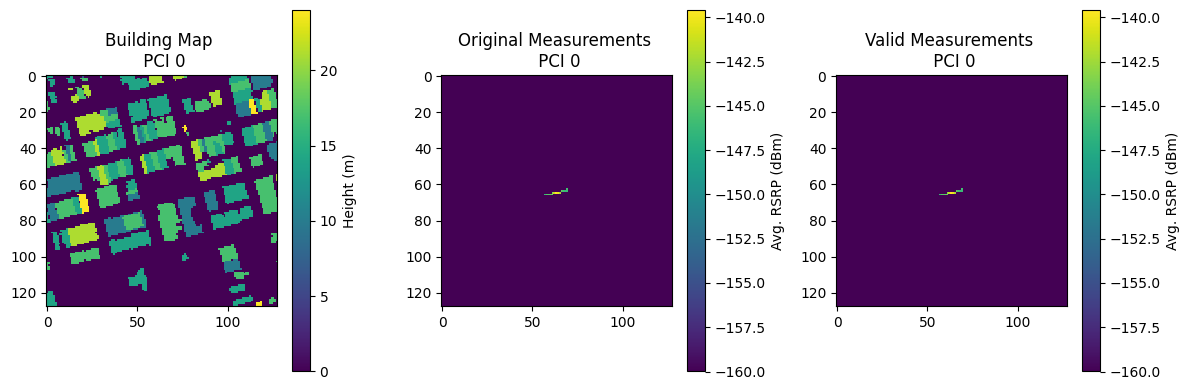

In [9]:
# Generate a list of tuples (numpy_row, numpy_col, rsrp) by converting the (lat, lon) into local coordinates
measurement = np.empty([len(measurement_data_filtered["latitude"]), 3])
measurement[:, 0] = measurement_data_filtered["latitude"]
measurement[:, 1] = measurement_data_filtered["longitude"]
measurement[:, 2] = measurement_data_filtered["rsrp"]

top_left_coord_x_utm,top_left_coord_y_utm, _   = gps_to_utm_xy(
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'].item()[1],
    cell_info_df[cell_info_df["PCI"] == which_PCI]['top-left_lat_lon'].item()[0],
    utm_epsg)

for idx, point in enumerate(measurement):
    mea_x_utm, mea_y_utm, _ = gps_to_utm_xy(measurement[idx,1], measurement[idx,0], utm_epsg)
    row = top_left_coord_y_utm - mea_y_utm 
    col =  mea_x_utm - top_left_coord_x_utm
    
    measurement[idx, 0] = row
    measurement[idx, 1] = col

ground_truth_list = measurement

print("Total number of measurements: ", len(ground_truth_list))

ground_truth_tmp = np.empty((128, 128), dtype=object)
count_num_no_building = 0

for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128 or row < 0 or col < 0:
        # print("{}:{}".format(row,col))
        continue
    if ground_truth_tmp[row, col] is None:
        ground_truth_tmp[row, col] = np.array(point[2])
    else:
        ground_truth_tmp[row][col] = np.append(ground_truth_tmp[row][col], point[2])

ground_truth_arr = np.empty((128, 128))
for row in range(128):
    for col in range(128):
        if ground_truth_tmp[row, col] is None:
            ground_truth_arr[row][col] = -160
        else:
            # ground_truth_arr[row][col] = ground_truth_tmp[row,col].mean()
            # ground_truth_arr[row][col] = np.median(ground_truth_tmp[row,col])
            ground_truth_arr[row][col] = 10 * np.log10( ( 10 ** ( ground_truth_tmp[row,col]/ 10)  ).mean() )

# Filter out the pixels blocked by the building (e.g., due to GPS and/or geographical data error)
condition = (ground_truth_arr != -160) & (building_map_npy_res_4 != 0)

ground_truth_arr_valid = ground_truth_arr.copy()
ground_truth_arr_valid[condition] = -160  # Update values

print("Total # of pixels after rasterization to 4m resolution: {}".format(np.sum(ground_truth_arr != -160))) 
print("Total # of valid pixels (no overlapping with buildings):  {}".format(np.sum(ground_truth_arr_valid != -160)))
  
# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(building_map_npy_res_4, interpolation='none')
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) TX positional map
im_ori_mea = axes[1].imshow(ground_truth_arr, interpolation='none')
axes[1].set_title('Original Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ori_mea, ax=axes[1])
cbar_db.set_label('Avg. RSRP (dBm)')

# 3) Pathloss
im_valid_mea = axes[2].imshow(ground_truth_arr_valid, interpolation='none')
axes[2].set_title('Valid Measurements \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_valid_mea, ax=axes[2])
cbar_db_flip.set_label('Avg. RSRP (dBm)')

plt.tight_layout()
plt.show()

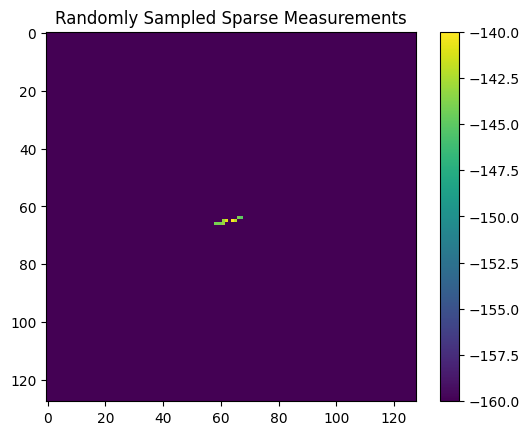

In [10]:
ss_map = np.full((128, 128), -160)

# Get valid positions (where ground_truth_arr_valid != -160)
valid_positions = np.argwhere(ground_truth_arr_valid != -160)  # Get (row, col) indices
    
# Randomly select SS_NUM positions from valid ones
# Note that the selected measurements vary from run to run if no seed is specified

selected_indices = valid_positions[np.random.choice(len(valid_positions), SS_NUM, replace=False)]

# Copy values from the original array to the ss_map at selected positions
for row, col in selected_indices:
    ss_map[row, col] = ground_truth_arr_valid[row, col]
    # Save the positions to rt_dict for raytracing
    rt_dict["rel_top_left_y"].append(row)
    rt_dict["rel_top_left_x"].append(col)
    center_x, center_y = top_left_to_center(row, col, 128, 128)
    rt_dict["rel_center_x"].append(center_x)
    rt_dict["rel_center_y"].append(center_y)
    


    
plt.imshow(ss_map, interpolation='none')
plt.title("Randomly Sampled Sparse Measurements")
plt.colorbar()
plt.show()

In [11]:
# Prepare the RT results:
rt_df = pd.DataFrame(rt_dict)
rt_df

,rel_top_left_x,rel_top_left_y,rel_center_x,rel_center_y
0,59,66,2.0,5.0
1,60,66,2.0,4.0
2,58,66,2.0,6.0
3,65,65,1.0,-1.0
4,64,65,1.0,0.0
5,66,64,0.0,-2.0
6,61,65,1.0,3.0
7,62,65,1.0,2.0
8,67,64,0.0,-3.0
9,61,66,2.0,3.0


In [12]:
# Array configurations

# Transmitter array (single isotropic element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="tr38901",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="V"
)

# Random select 10 receivers form valid_positions (Outdoor positions)
# for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=10, replace=False)]):
for index, row in rt_df.iterrows():
    rx = Receiver(
        name=f"rx_{index}",
        position=(np.mean((-1 *(row["rel_center_y"]+1)*4, -1 *row["rel_center_y"]*4)),   np.mean((-1 * (row["rel_center_x"]+1)*4, -1 * row["rel_center_x"]*4)),1.5),
        orientation=[0, 0, 0] 
    )
    scene.add(rx)

# Transmitter configuration
tx = Transmitter(
    name="tx",
    position=[0, 0, 25],  # Elevated position
    orientation=[-1 * (cell_info_df[cell_info_df["PCI"] == which_PCI]['azimuth'].item() - 90) / 180 * np.pi, 0, 0]  # 210° azimuth tilt
)

scene.add(tx)

# Validate setup
scene.preview(show_orientations=True)


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [13]:
# Configure simulation parameters
scene.frequency = cell_info_df[cell_info_df["PCI"] == which_PCI]['freq'].item()
print("Frequency: ", scene.frequency)
scene.synthetic_array = True  # Optimize for array calculations

# Perform ray tracing
paths = scene.compute_paths(
    max_depth=3,
    diffraction=True,
    scattering=False,
    scat_keep_prob=0.0001,
    num_samples=7e6, 
)

Frequency:  tf.Tensor(3670000000.0, shape=(), dtype=float32)


In [14]:
# Convert paths to analyzable format
ray_data = paths.to_dict()

# Create structured dataset
def create_ray_dataset(ray_dict, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        # 'rx_coord':[]
    }
    
    type_map = {0: "LoS", 1: "Reflected", 2: "Diffracted", 3: "Scattered"}
    
    a = ray_dict["a"].numpy().squeeze()
    tau = ray_dict["tau"].numpy().squeeze()
    types = ray_dict["types"].numpy().squeeze()
    mask = ray_dict["mask"].numpy().squeeze()
    phi_r = ray_dict["phi_r"].numpy().squeeze()
    phi_t = ray_dict["phi_t"].numpy().squeeze()
    theta_r = ray_dict["theta_r"].numpy().squeeze()
    theta_t = ray_dict["theta_t"].numpy().squeeze()
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        
        # Filter out the RX which have no rays related
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    dataset["type"].append(type_map[types[sub_idx]])
                    dataset["a"].append(a[idx,sub_idx])
                    dataset["tau"].append(tau[idx,sub_idx])
                    dataset["freq"].append(frequency)
                    
                    # Store the list instead of np.array to avoid the space sepreator in csv
                    #dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
                    dataset["rx_id"].append(idx)

    return pd.DataFrame(dataset)

# Generate analysis dataframe
df = create_ray_dataset(ray_data, frequency=28e9)
df.head()

,freq,rx_id,type,phi_r,phi_t,theta_r,theta_t,a,tau
0,2.800000e+10,0,LoS,0.426628,-2.714965,0.799371,2.342221,1.345002e-05+0.000000e+ 00j,0.000000e+00
1,2.800000e+10,0,Reflected,0.281798,0.241185,1.705425,1.705425,5.379518e-06+6.521340e- 07j,5.461279e-07
2,2.800000e+10,0,Reflected,0.426628,-2.714965,2.402226,2.402226,6.233342e-06-4.618462e- 07j,7.191694e-09
3,2.800000e+10,0,Reflected,1.555967,2.038020,1.831803,1.831803,-1.368357e-07+1.302883e- 07j,2.301048e-07
4,2.800000e+10,0,Reflected,-0.888778,-1.716574,1.990838,1.990838,-5.585346e-06+1.320052e- 06j,1.043216e-07


In [15]:

# Compute the absolute values of 'a' and sum by 'rx_id'
signal_strength = df.groupby('rx_id')['a'].apply(lambda x: 10 * np.log10(np.power(np.abs(x),2).sum())).reset_index()

# Rename the column for clarity
signal_strength.columns = ['rx_id', 'Path Gain']
print(len(signal_strength))

# Merge the signal strength DataFrame with the measurement DataFrame
signal_strength_db = signal_strength.merge(rt_df, left_on='rx_id', right_index=True, how='left')

signal_strength_db


10


,rx_id,Path Gain,rel_top_left_x,rel_top_left_y,rel_center_x,rel_center_y
0,0,-87.922201,59,66,2.0,5.0
1,1,-88.413010,60,66,2.0,4.0
2,2,-89.400558,58,66,2.0,6.0
3,3,-84.045067,65,65,1.0,-1.0
4,4,-85.515413,64,65,1.0,0.0
5,5,-82.551289,66,64,0.0,-2.0
6,6,-87.688913,61,65,1.0,3.0
7,7,-87.131023,62,65,1.0,2.0
8,8,-79.700408,67,64,0.0,-3.0
9,9,-87.556162,61,66,2.0,3.0


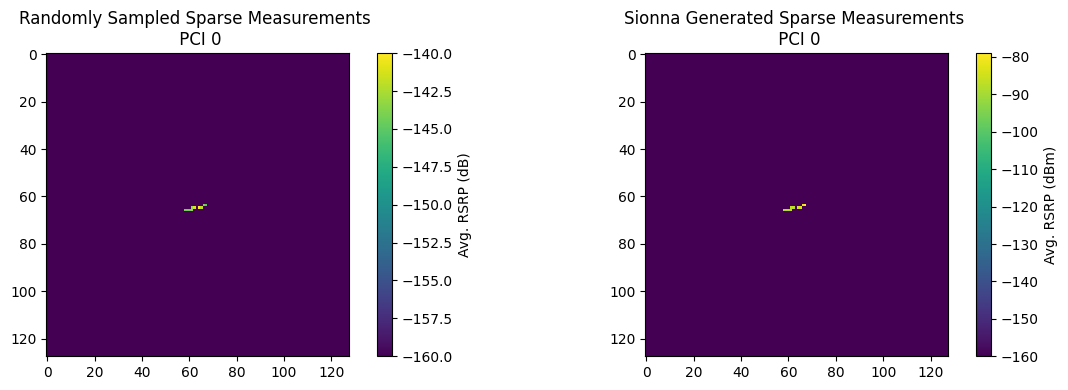

In [16]:
rt_ss_map = np.full((128, 128), -160)

for index, row in signal_strength_db.iterrows():
    
    rt_ss_map[int(row["rel_top_left_y"])][int(row["rel_top_left_x"])] = row["Path Gain"]



# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(ss_map, interpolation='none')
axes[0].set_title('Randomly Sampled Sparse Measurements \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Avg. RSRP (dB)')

# 2) TX positional map
im_ori_mea = axes[1].imshow(rt_ss_map, interpolation='none')
axes[1].set_title('Sionna Generated Sparse Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ori_mea, ax=axes[1])
cbar_db.set_label('Avg. RSRP (dBm)')


plt.tight_layout()
plt.show()



## 3. **Model Inference**
- 1st U-Net: Isotropic antenna pattern prediction

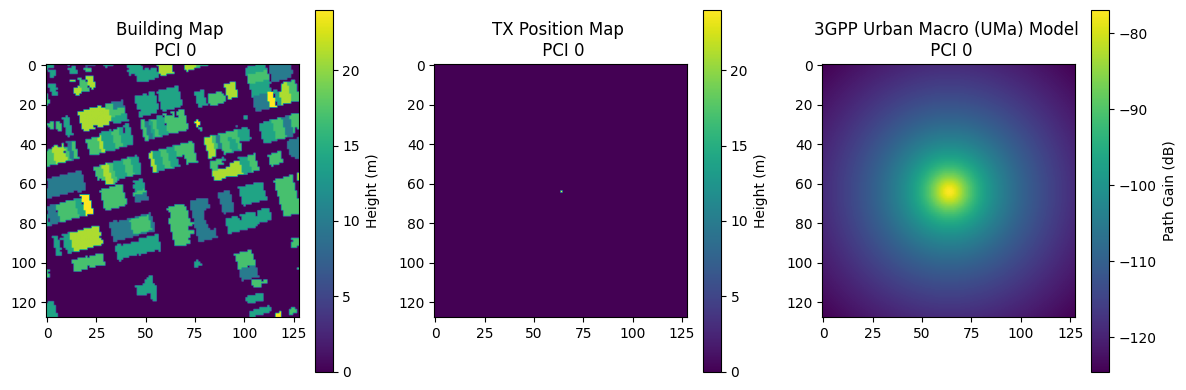

In [17]:
# Construct the TX position channel
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
tx_height = 24
tx_position_channel = np.full((128, 128), 0, dtype=int)
# tx_height = np.max(building_height_arr)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height

distance = np.arange(0, 1450, 1)

# lookup table for path_loss_res, resolution=1 meter
path_loss_res, _ =  pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)

path_loss_heat_map = np.full((128, 128), 0, dtype=float)

for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2) 
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]

net_iso = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net_iso.to(device=device)

# Load the state dict
state_dict = torch.load(state_dict_1st_UNet, map_location=device)
net_iso.load_state_dict(state_dict)

# Combine all the channels together
combined_input = np.zeros((3, 128, 128), dtype=float)
combined_input[0,:, :] = np.copy(building_map_npy_res_4)
combined_input[1,:, :] = tx_position_channel
combined_input[2,:, :] = path_loss_heat_map

# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(combined_input[0,:, :])
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) TX positional map
im_tx_pos = axes[1].imshow(combined_input[1,:, :])
axes[1].set_title('TX Position Map \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_tx_pos, ax=axes[1])
cbar_db.set_label('Height (m)')

# 3) Pathloss
im_uma = axes[2].imshow(combined_input[2,:, :])
axes[2].set_title('3GPP Urban Macro (UMa) Model \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_uma, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()

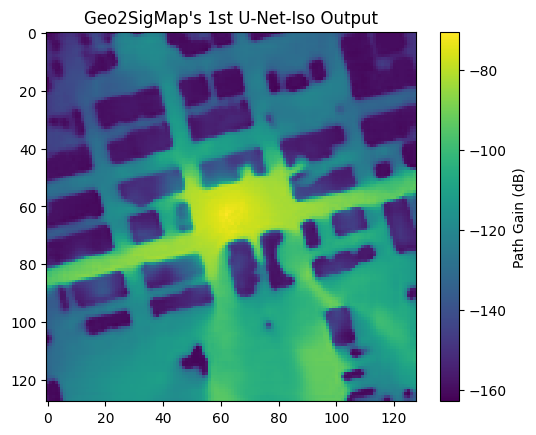

In [18]:
# Eval
images =  torch.as_tensor(combined_input.copy()).float().contiguous()

# Since we load the data manually, add batch dimension to the front of the data
images = images[None,:, :, :]

net_iso.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)

with torch.no_grad():
    output = net_iso(images).squeeze().cpu()

output_iso_UNet = output.squeeze().cpu().numpy()

plt.imshow(output_iso_UNet, interpolation='none')
plt.title("Geo2SigMap's 1st U-Net-Iso Output")
cbar_db = plt.colorbar()
cbar_db.set_label('Path Gain (dB)')
plt.show()

## 3. **Model Inference**
- 2nd U-Net: Fine-grained prediction with sparse measurements

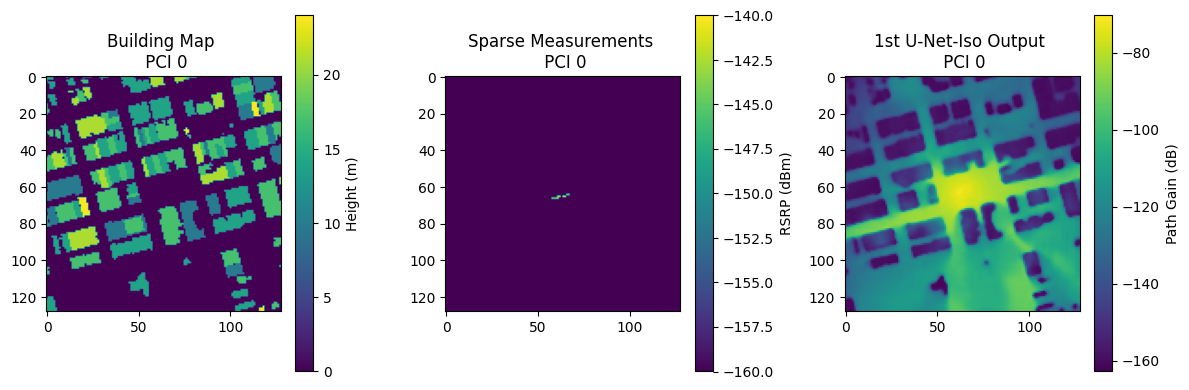

In [19]:
# 1. Create the model
net = UNet(n_channels=3, n_classes=1, bilinear=False, pathloss=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)

# 2. Load the state dict
state_dict = torch.load(state_dict_2nd_UNet, map_location=device)
net.load_state_dict(state_dict)

combined_input = np.zeros((3, 128, 128), dtype=float)

rt_combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_map_npy_res_4
combined_input[1,:, :] = ss_map
combined_input[2,:, :] = output_iso_UNet

rt_combined_input[0,:, :] = building_map_npy_res_4
rt_combined_input[1,:, :] = rt_ss_map
rt_combined_input[2,:, :] = output_iso_UNet

# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(combined_input[0,:,:])
axes[0].set_title('Building Map \n PCI {}'.format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('Height (m)')

# 2) Sparse Measurements
im_ss = axes[1].imshow(combined_input[1,:,:])
axes[1].set_title('Sparse Measurements \n PCI {}'.format(which_PCI))
cbar_db = plt.colorbar(im_ss, ax=axes[1])
cbar_db.set_label('RSRP (dBm)')

# 3) 1st U-Net output
im_1st_output = axes[2].imshow(combined_input[2,:,:])
axes[2].set_title('1st U-Net-Iso Output \n PCI {}'.format(which_PCI))
cbar_db_flip = plt.colorbar(im_1st_output, ax=axes[2])
cbar_db_flip.set_label('Path Gain (dB)')

plt.tight_layout()
plt.show()


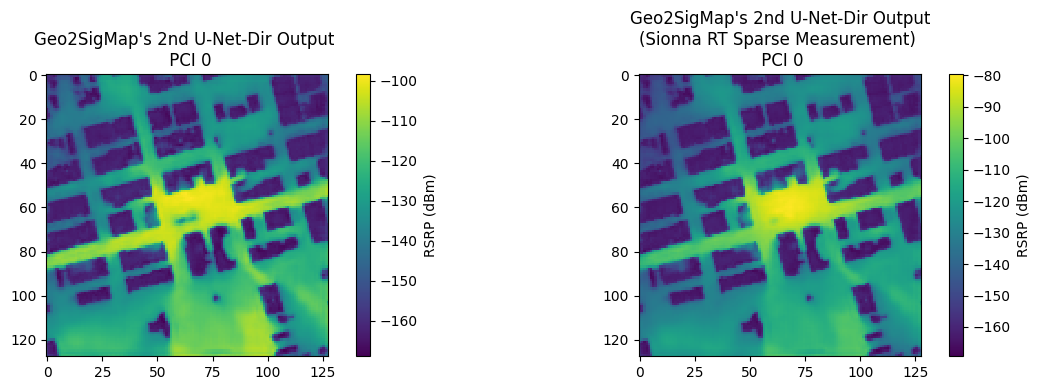

In [20]:
# 4. Eval
images = torch.as_tensor(combined_input.copy()).float().contiguous()
rt_images = torch.as_tensor(rt_combined_input.copy()).float().contiguous()

# Since we directly load the data manually, add batch dimension to the front of data
images = images[None,:, :, :]
rt_images = rt_images[None,:, :, :]

net.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
rt_images = rt_images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)


with torch.no_grad():
    output = net(images).cpu()
    rt_output = net(rt_images).cpu()
output = output.squeeze().cpu().numpy()
rt_output = rt_output.squeeze().cpu().numpy()



# Create side-by-side plots for original, cropped, down-sampled building map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 1) Building map
im_bmap = axes[0].imshow(output, interpolation='none')
axes[0].set_title("Geo2SigMap's 2nd U-Net-Dir Output \n PCI {}".format(which_PCI))
cbar_raw = plt.colorbar(im_bmap, ax=axes[0])
cbar_raw.set_label('RSRP (dBm)')

# 2) TX positional map
im_ori_mea = axes[1].imshow(rt_output, interpolation='none')
axes[1].set_title("Geo2SigMap's 2nd U-Net-Dir Output\n(Sionna RT Sparse Measurement) \n PCI {}".format(which_PCI))
cbar_db = plt.colorbar(im_ori_mea, ax=axes[1])
cbar_db.set_label('RSRP (dBm)')


plt.tight_layout()
plt.show()




## 4. **Performance Evaluation**: Quantitative comparison with ground truth (Field measurements)


In [21]:
def evaluate_predictions(y_true, y_pred, model_name):
    """Calculate comprehensive evaluation metrics"""
    mask = y_true != -160  # Ignore invalid pixels
    
    metrics = {
        'RMSE (dB)': root_mean_squared_error(y_true[mask], y_pred[mask]),
        'MAE (dB)': mean_absolute_error(y_true[mask], y_pred[mask]),
    }
    
    print(f"\n{model_name} Performance:")
    for k, v in metrics.items():
        print(f"- {k}: {v:.2f}")
    
    return metrics

# Compare all predictions
metrics_iso = evaluate_predictions(ground_truth_arr_valid, output_iso_UNet, "1st U-Net (Isotropic)")
metrics_adaptive = evaluate_predictions(ground_truth_arr_valid, output, "2nd U-Net (Adaptive)")

rt_metrics_adaptive = evaluate_predictions(ground_truth_arr_valid, rt_output, "2nd U-Net (Adaptive, Using Sionna RT Sparse Measurement) ")


1st U-Net (Isotropic) Performance:
- RMSE (dB): 69.42
- MAE (dB): 69.40

2nd U-Net (Adaptive) Performance:
- RMSE (dB): 27.40
- MAE (dB): 25.95

2nd U-Net (Adaptive, Using Sionna RT Sparse Measurement)  Performance:
- RMSE (dB): 57.79
- MAE (dB): 57.54
